In [1]:
import pandas as pd
from util import *
from forecast import *
import matplotlib.pyplot as plt
from hungarian import *

In [2]:
%matplotlib inline

In [3]:
#Load up the elo dataframe
games = Util.read_games("data/nfl_games.csv")
forecasts = Forecast.forecast(games)
elos = pd.DataFrame(games)

In [32]:
elos.tail()

,date,elo1,elo2,elo_diff,elo_prob1,my_prob1,neutral,playoff,result1,score1,score2,season,team1,team2,week_in_season
15982,2017-12-31,,,215.650300,NaN,NaN,0,0,NaN,NaN,NaN,2017,MIN,CHI,17
15981,2017-12-31,,,125.685010,NaN,NaN,0,0,NaN,NaN,NaN,2017,MIA,BUF,17
15980,2017-12-31,,,113.361158,NaN,NaN,0,0,NaN,NaN,NaN,2017,IND,HOU,17
15986,2017-12-31,,,372.577130,NaN,NaN,0,0,NaN,NaN,NaN,2017,PIT,CLE,17
15995,2017-12-31,,,146.116797,NaN,NaN,0,0,NaN,NaN,NaN,2017,LAR,SF,17


In [5]:
elos.dtypes

date          object
elo1          object
elo2          object
elo_diff     float64
elo_prob1    float64
my_prob1     float64
neutral        int64
playoff        int64
result1      float64
score1       float64
score2       float64
season         int64
team1         object
team2         object
dtype: object

In [6]:
# Convert to datetime objects
#elos['season'] = pd.to_datetime(elos['season'], errors='coerce')
elos['date'] = pd.to_datetime(elos['date'], errors='coerce')

In [7]:
elos.dtypes

date         datetime64[ns]
elo1                 object
elo2                 object
elo_diff            float64
elo_prob1           float64
my_prob1            float64
neutral               int64
playoff               int64
result1             float64
score1              float64
score2              float64
season                int64
team1                object
team2                object
dtype: object

In [8]:
elos = elos.sort_values('date', ascending=True)

In [9]:
week_in_season = []
# Get week in season for forecasting
for group, df in elos.groupby('season'):
    df = df.sort_values('date', ascending=True)
    teams_played = set()
    week = 1
    for team1, team2 in zip(df['team1'], df['team2']):
        if team1 in teams_played or team2 in teams_played:
            week += 1
            teams_played = set()
        teams_played.add(team1)
        teams_played.add(team2)
        week_in_season.append(week)
elos['week_in_season'] = week_in_season

In [33]:
elos[elos['season'].isin([2016])]

,date,elo1,elo2,elo_diff,elo_prob1,my_prob1,neutral,playoff,result1,score1,score2,season,team1,team2,week_in_season
15473,2016-09-08,1637.1131581531,1633.57926535012,102.703824,0.597369,0.643643,0,0,1.0,21.0,20.0,2016,DEN,CAR,1
15481,2016-09-11,1505.68227372661,1444.02306103417,160.998832,0.674610,0.716422,0,0,1.0,23.0,14.0,2016,HOU,CHI,1
15486,2016-09-11,1612.61322429379,1605.4217557152,106.942242,0.602422,0.649219,0,0,0.0,21.0,23.0,2016,ARI,NE,1
15485,2016-09-11,1445.98789369703,1468.87798186004,74.634753,0.560306,0.605786,0,0,0.0,19.0,20.0,2016,DAL,NYG,1
15484,2016-09-11,1484.30206131341,1502.85315875748,86.216001,0.566450,0.621589,0,0,0.0,35.0,39.0,2016,IND,DET,1
15483,2016-09-11,1634.55869815528,1438.73814816582,305.053106,0.817784,0.852711,0,0,1.0,12.0,10.0,2016,SEA,MIA,1
15482,2016-09-11,1475.49833239743,1518.80808993309,60.909969,0.531174,0.586769,0,0,1.0,13.0,7.0,2016,BAL,BUF,1
15479,2016-09-11,1485.83297419564,1412.23649632018,174.789349,0.689509,0.732270,0,0,0.0,24.0,31.0,2016,ATL,TB,1
15478,2016-09-11,1522.16390912172,1578.45811806017,40.861462,0.512526,0.558535,0,0,0.0,22.0,23.0,2016,NYJ,CIN,1
15477,2016-09-11,1388.72405911239,1582.43588564451,-103.682375,0.322802,0.355066,0,0,0.0,23.0,27.0,2016,JAX,GB,1


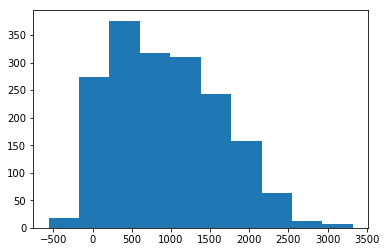

In [11]:
plt.hist(elos.groupby(['season', 'week_in_season']).sum()['elo_diff'])
plt.show()

In [48]:
elos_visitor = elos.copy()
elos_visitor['elo_prob1'] = 1 - elos['elo_prob1']
elos_visitor['team1'] = elos['team2']
elos_visitor['team2'] = elos['team1']
elos_visitor['result1'] = 1 - elos['result1']


elos_both = elos.append(elos_visitor)
results = []
for year, group in elos_both[elos_both['season'] > 1980].groupby('season'):
    if year == 2017:
        print(group)
        break
    teams = dict(zip(set(group['team1']), range(len(set(group['team1'])))))
    data = np.ones((len(teams), len(teams)))
    data = data*1000
    for _, row in group[group['week_in_season'] <= 15].iterrows():
        data[teams[row['team1']], row['week_in_season']-1] = row['elo_prob1']
    hungarian = Hungarian(data)
    hungarian.calculate()
    number_to_team = dict(zip(teams.values(), teams.keys()))
    print(hungarian.get_total_potential())
    for _team, _week in hungarian.get_results():
        if _week < 17:
            temp = group[group['team1'] == number_to_team[_team]]
            temp = temp[temp['week_in_season'] == _week + 1]['result1'].values
            if temp.any():
                print(temp)
            results.append((_week+1, number_to_team[_team], year, temp))
df = pd.DataFrame(results)

13003.0197189
[ 1.]
[ 1.]
[ 1.]
[ 1.]
15003.2402597
[ 1.]
[ 1.]
[ 1.]
13002.9439641
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
13002.4967511
[ 1.]
[ 1.]
[ 1.]
13002.6813235
[ 1.]
[ 1.]
[ 1.]
[ 1.]
13002.1603984
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
13002.499156
[ 1.]
[ 1.]
[ 1.]
13003.2439972
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
13003.1175749
[ 1.]
[ 1.]
[ 1.]
[ 1.]
13002.8058205
[ 1.]
[ 1.]
13002.8159122
[ 1.]
[ 1.]
[ 1.]
13002.9011588
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
13002.9282638
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
13002.7074514
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
15002.5491144
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
15002.9423554
[ 1.]
[ 1.]
[ 1.]
[ 1.]
15002.9415004
[ 1.]
[ 1.]
15002.6268858
[ 1.]
16002.7198251
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
16002.773481
[ 1.]
[ 1.]
[ 1.]
16002.8433625
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
17002.839355
[ 1.]
[ 1.]
[ 1.]
[ 1.]
17003.0730839
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
17002.8352935
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
17002.8312361
[ 1.]
[ 1.]
17002

In [45]:
df.head()

,0,1,2,3
0,4,WSH,1981,"6837 0.0 Name: result1, dtype: float64"
1,15,TEN,1981,"6989 0.0 Name: result1, dtype: float64"
2,7,NO,1981,"6873 0.0 Name: result1, dtype: float64"
3,14,NE,1981,"6976 0.0 Name: result1, dtype: float64"
4,8,TB,1981,"6897 0.0 Name: result1, dtype: float64"
